# ST>A | Special Topics in Astrodynamics | ae4889

In [1]:
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras_visualizer import visualizer
from IPython.core.display import Image, display

print(f"tensorflow version: {tf.__version__}")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.spines.top'] = plt.rcParams['axes.spines.right'] = False
np.set_printoptions(precision=4, suppress=True)

JULIAN_DAY = 86400.0
launch_window22 = 8304.5 * JULIAN_DAY

departure_range = np.array([-25 * JULIAN_DAY, 25 * (JULIAN_DAY - 1)]) + launch_window22
arrival_range = np.array([(-25 + 60) * JULIAN_DAY, (25 + 450) * (JULIAN_DAY - 1)]) + launch_window22
time_of_flight_range = arrival_range - departure_range

raw_data = np.loadtxt('Output.txt', skiprows=1, delimiter=',')

column_names = ['departure time', 'arrival time', '∆V_1', '∆V_2']
raw_dataset = pd.DataFrame(data=raw_data, columns=column_names)

column_names.insert(1, "time of flight")
raw_dataset['time of flight'] = raw_dataset["arrival time"] - raw_dataset["departure time"]

raw_dataset = raw_dataset[column_names]

sample_size = 100000
batch_size = 100
n_layers = 3
n_nodes = 50

print(f'sample = {sample_size}, batch = {batch_size}')

tensorflow version: 2.0.0
sample = 100000, batch = 100


In [2]:
raw_data.shape

(100000, 4)

In [3]:
dataset = raw_dataset.copy()

### Raw Data

In [4]:
dataset

,departure time,time of flight,arrival time,∆V_1,∆V_2
0,715551566.0,17470756.0,733022322.0,3577.063946,4726.501883
1,719297160.0,26748392.0,746045552.0,4106.990821,5541.734301
2,716105905.0,9450037.0,725555942.0,126.185950,368.164990
3,715783574.0,24993606.0,740777180.0,3937.910408,5411.901896
4,717645486.0,13975971.0,731621457.0,3392.797231,4352.089213
...,...,...,...,...,...
99995,717738385.0,26494859.0,744233244.0,4011.004073,5455.659695
99996,715605216.0,15517444.0,731122660.0,3245.808873,4170.297589
99997,719621735.0,33804428.0,753426163.0,3864.150243,4979.463354
99998,715664576.0,32494544.0,748159120.0,3835.606847,5180.600242


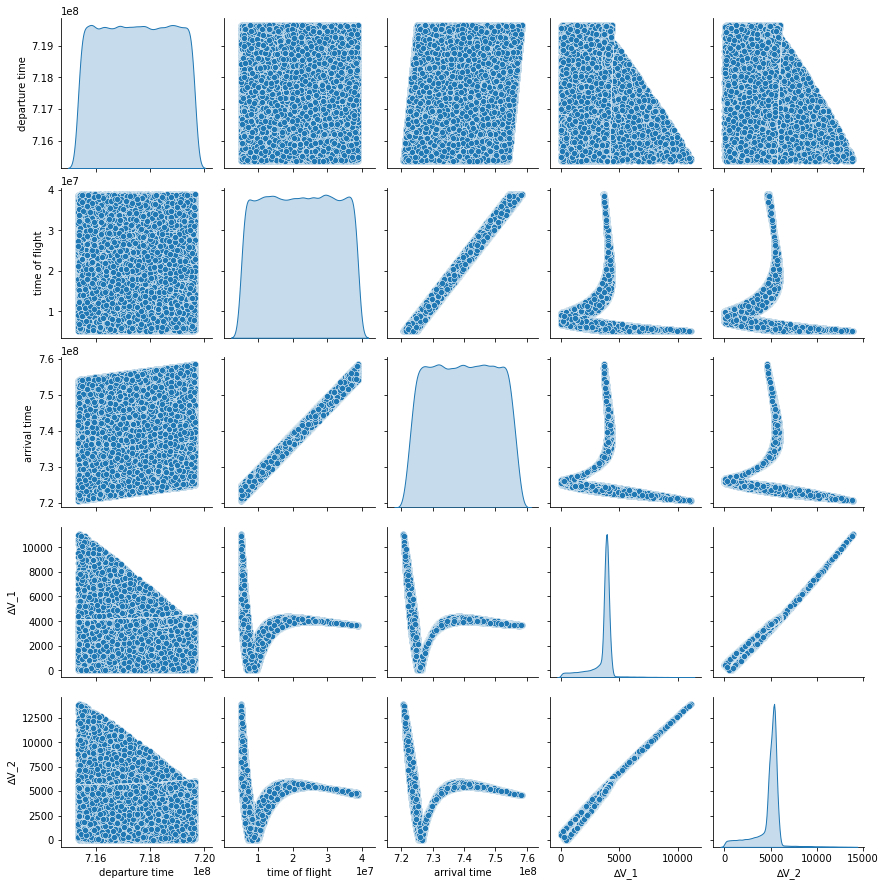

In [5]:
sns.pairplot(dataset, diag_kind="kde")

### Split Data Up

In [6]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Training Data

In [7]:
train_dataset

,departure time,time of flight,arrival time,∆V_1,∆V_2
3582,718035940.0,27976785.0,746012725.0,3981.084645,5392.953117
60498,717910597.0,24590254.0,742500851.0,4053.631465,5540.259321
53227,718138386.0,30433933.0,748572319.0,3910.420687,5242.287877
21333,715573355.0,12946001.0,728519356.0,2421.933756,2876.218035
3885,717085731.0,11178178.0,728263909.0,2088.231125,2338.694366
...,...,...,...,...,...
27389,718118387.0,36832806.0,754951193.0,3708.553195,4795.329748
8871,716602021.0,23969814.0,740571835.0,3968.510231,5446.753041
47812,716822804.0,11254266.0,728077070.0,2002.118141,2227.861571
4539,718662353.0,22917070.0,741579423.0,4137.319457,5682.749848


In [8]:
train_dataset.describe()

,departure time,time of flight,arrival time,∆V_1,∆V_2
count,8.000000e+04,8.000000e+04,8.000000e+04,80000.000000,80000.000000
mean,7.175082e+08,2.208255e+07,7.395907e+08,3547.470034,4731.302574
std,1.249618e+06,9.748404e+06,9.821713e+06,1085.220861,1498.627019
min,7.153488e+08,5.184034e+06,7.205822e+08,0.223027,0.132175
25%,7.164207e+08,1.365357e+07,7.311441e+08,3568.425213,4655.627513
50%,7.175060e+08,2.213882e+07,7.396420e+08,3840.305588,5134.681073
75%,7.185978e+08,3.052158e+07,7.480382e+08,3981.377501,5418.933613
max,7.196688e+08,3.887948e+07,7.585331e+08,11091.914738,13941.037853


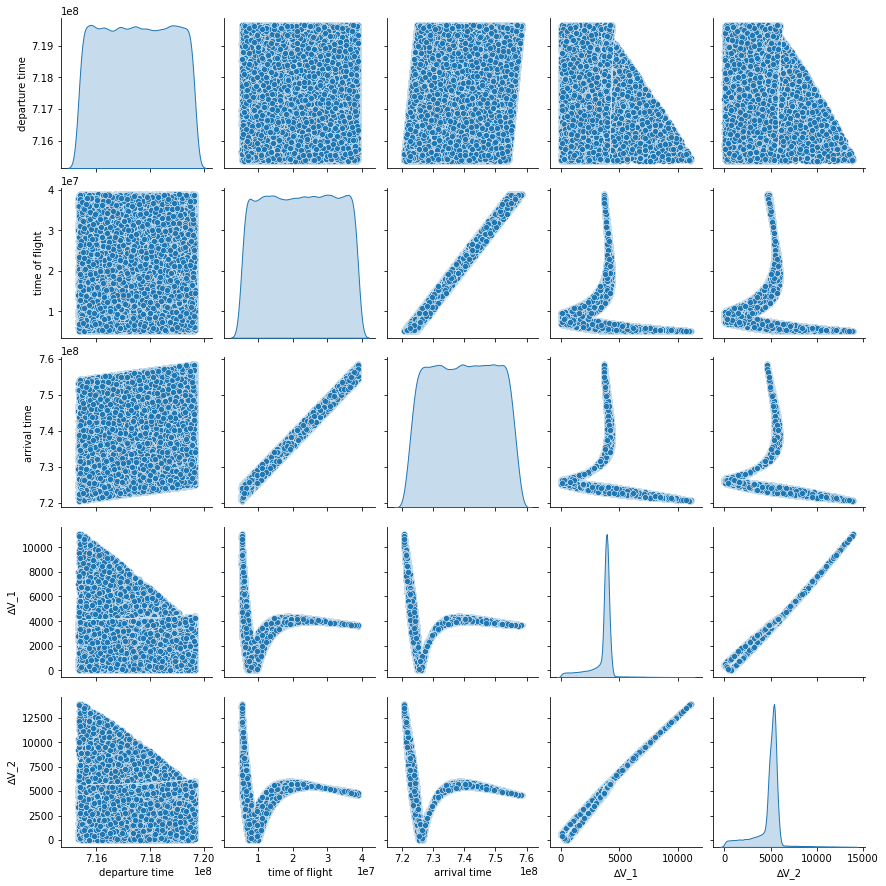

In [9]:
sns.pairplot(train_dataset, diag_kind="kde")

## Normalisation

In [10]:
def normalise_dataset(dataset):
    for i, the_range in zip(column_names, [departure_range, time_of_flight_range, arrival_range]):
        dataset[i] = (dataset[i] - the_range.min()) / (the_range.max() - the_range.min())

    for column in column_names[3:]:
        column_stats = dataset[column].describe()
        dataset[column] = (dataset[column] - column_stats.loc['mean']) / column_stats.loc['std']

    return dataset

train_data_normalised = normalise_dataset(train_dataset.copy())

In [11]:
train_data_normalised

,departure time,time of flight,arrival time,∆V_1,∆V_2
3582,0.622027,0.676433,0.670251,0.399563,0.441504
60498,0.593012,0.575929,0.577871,0.466413,0.539799
53227,0.645741,0.749355,0.737581,0.334449,0.340969
21333,0.051981,0.230357,0.210087,-1.037150,-1.237856
3885,0.402070,0.177892,0.203367,-1.344647,-1.596533
...,...,...,...,...,...
27389,0.641112,0.939258,0.905377,0.148434,0.042724
8871,0.290099,0.557516,0.527128,0.387977,0.477404
47812,0.341207,0.180150,0.198452,-1.423998,-1.670490
4539,0.767031,0.526273,0.553632,0.543529,0.634879


In [12]:
train_data_normalised.describe()

,departure time,time of flight,arrival time,∆V_1,∆V_2
count,80000.000000,80000.000000,80000.000000,8.000000e+04,8.000000e+04
mean,0.499856,0.501507,0.501319,7.478906e-16,-4.193090e-16
std,0.289265,0.289308,0.258361,1.000000e+00,1.000000e+00
min,0.000009,0.000001,0.001300,-3.268687e+00,-3.157003e+00
25%,0.248117,0.251356,0.279130,1.930960e-02,-5.049626e-02
50%,0.499353,0.503177,0.502668,2.698396e-01,2.691654e-01
75%,0.752090,0.751956,0.723532,3.998333e-01,4.588407e-01
max,1.000000,0.999998,0.999600,6.951990e+00,6.145449e+00


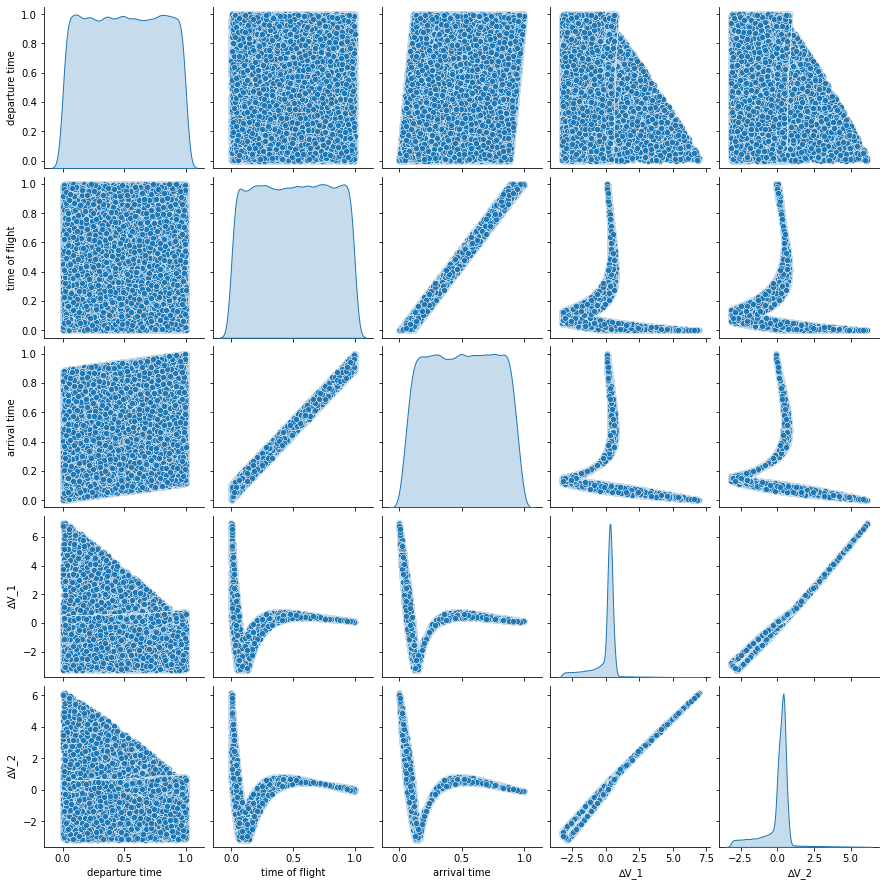

In [13]:
sns.pairplot(train_data_normalised, diag_kind="kde")

### Training data

In [14]:
train_data_normalised

,departure time,time of flight,arrival time,∆V_1,∆V_2
3582,0.622027,0.676433,0.670251,0.399563,0.441504
60498,0.593012,0.575929,0.577871,0.466413,0.539799
53227,0.645741,0.749355,0.737581,0.334449,0.340969
21333,0.051981,0.230357,0.210087,-1.037150,-1.237856
3885,0.402070,0.177892,0.203367,-1.344647,-1.596533
...,...,...,...,...,...
27389,0.641112,0.939258,0.905377,0.148434,0.042724
8871,0.290099,0.557516,0.527128,0.387977,0.477404
47812,0.341207,0.180150,0.198452,-1.423998,-1.670490
4539,0.767031,0.526273,0.553632,0.543529,0.634879


In [15]:
train_data_normalised.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
departure time,80000.0,4.998556e-01,0.289265,0.000009,0.248117,0.499353,0.752090,1.000000
time of flight,80000.0,5.015068e-01,0.289308,0.000001,0.251356,0.503177,0.751956,0.999998
arrival time,80000.0,5.013191e-01,0.258361,0.001300,0.279130,0.502668,0.723532,0.999600
∆V_1,80000.0,7.478906e-16,1.000000,-3.268687,0.019310,0.269840,0.399833,6.951990
∆V_2,80000.0,-4.193090e-16,1.000000,-3.157003,-0.050496,0.269165,0.458841,6.145449


## Model


In [16]:
model = keras.Sequential([
    layers.Dense(n_nodes, activation='relu', input_shape=[2]),
    *[layers.Dense(n_nodes, activation='relu') for _ in range(n_layers - 1)],
    layers.Dense(2)
])

model.compile(loss='mse',
              optimizer='adam',
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                150       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 102       
Total params: 5,352
Trainable params: 5,352
Non-trainable params: 0
_________________________________________________________________


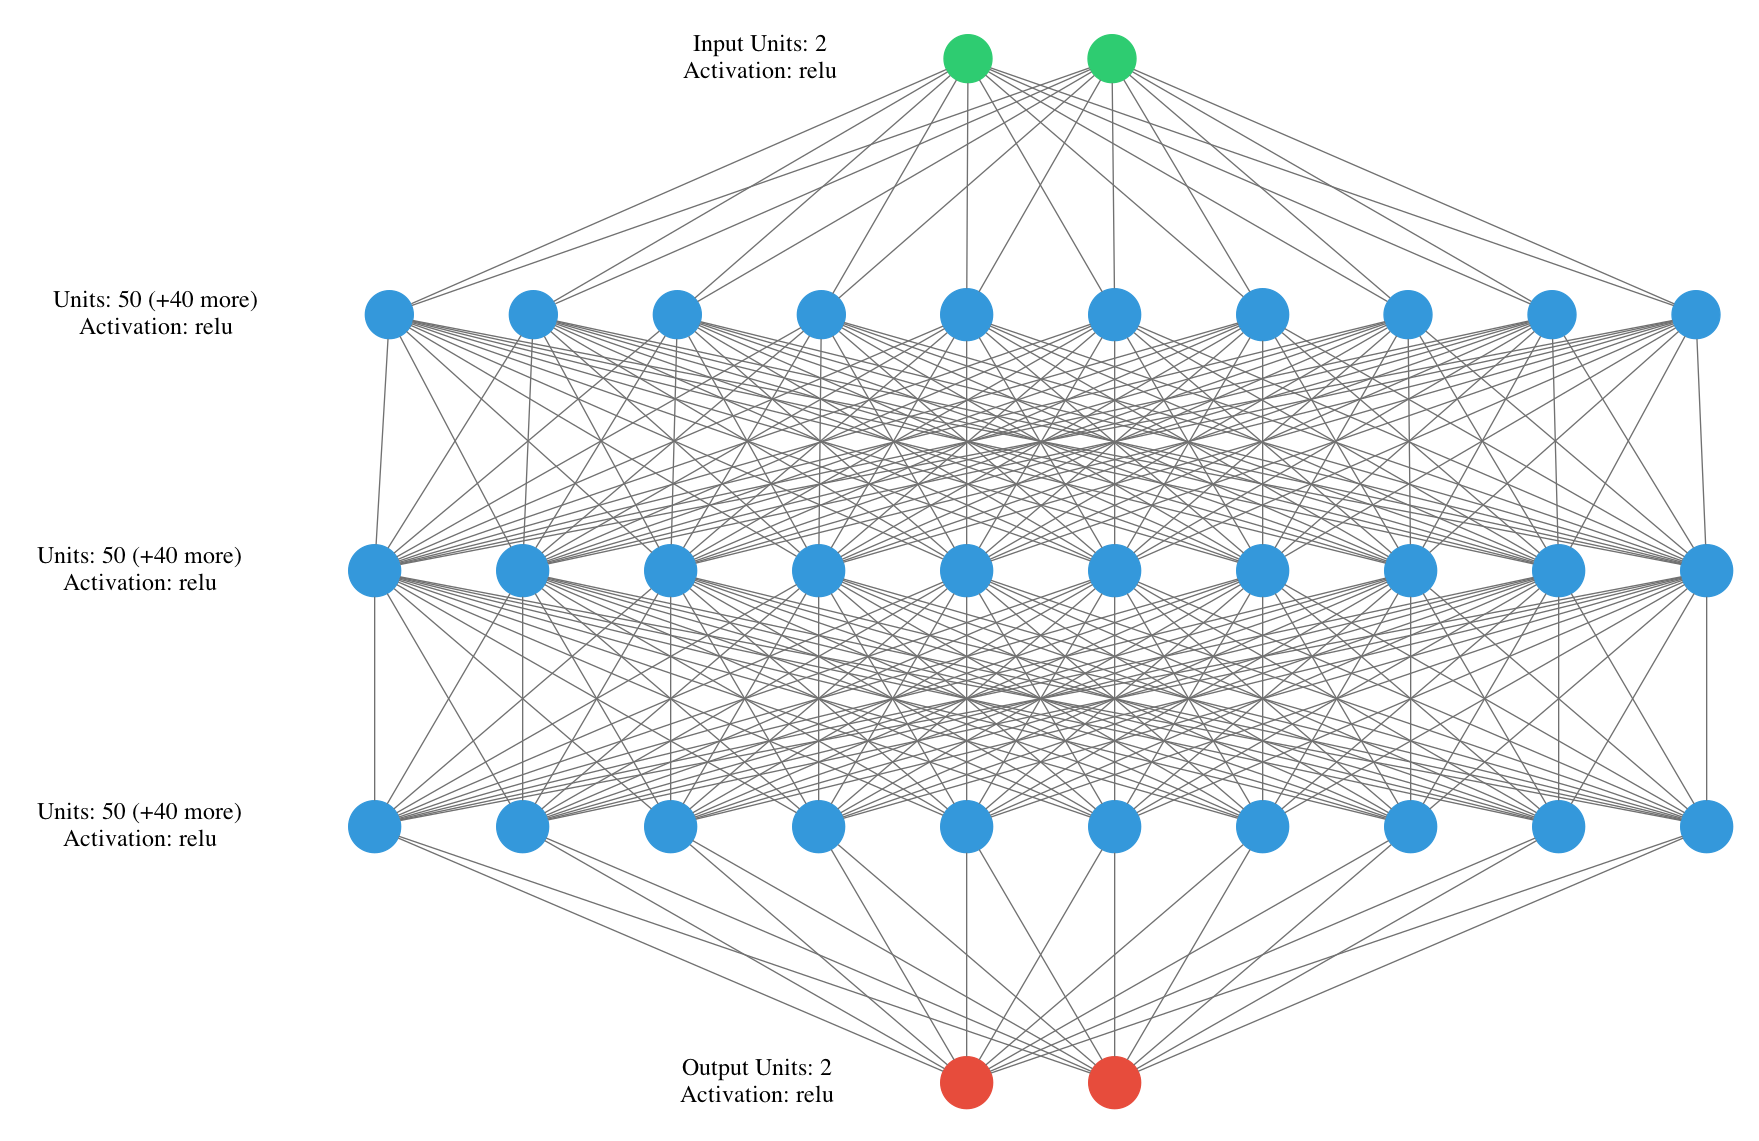

In [18]:
visualizer(model, format='png')
display((Image(filename='graph.png')))

In [19]:
%%time
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0.0005,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

history = model.fit(train_data_normalised[[column_names[0], column_names[1]]].to_numpy(),
                    train_data_normalised[[column_names[3], column_names[4]]].to_numpy(),
                    validation_split=0.2,
                    epochs=1000,
                    batch_size=batch_size,
                    callbacks=[early_stop])

Train on 64000 samples, validate on 16000 samples
Epoch 1/1000
64000/64000 [==============================] - 3s 44us/sample - loss: 0.2744 - accuracy: 0.7766 - val_loss: 0.0041 - val_accuracy: 0.9556
Epoch 2/1000
64000/64000 [==============================] - 2s 28us/sample - loss: 0.0024 - accuracy: 0.9514 - val_loss: 0.0015 - val_accuracy: 0.9586
Epoch 3/1000
64000/64000 [==============================] - 2s 27us/sample - loss: 0.0012 - accuracy: 0.9623 - val_loss: 9.2458e-04 - val_accuracy: 0.9697
Epoch 4/1000
64000/64000 [==============================] - 2s 29us/sample - loss: 8.8681e-04 - accuracy: 0.9668 - val_loss: 5.6365e-04 - val_accuracy: 0.9753
Epoch 5/1000
64000/64000 [==============================] - 2s 30us/sample - loss: 8.2874e-04 - accuracy: 0.9699 - val_loss: 9.8500e-04 - val_accuracy: 0.9775
Epoch 6/1000
64000/64000 [==============================] - 2s 29us/sample - loss: 6.1115e-04 - accuracy: 0.9731 - val_loss: 6.3131e-04 - val_accuracy: 0.9721
Epoch 7/1000
640

In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
22,0.000289,0.981812,0.000073,0.982250,22
23,0.000342,0.981172,0.000279,0.982000,23
24,0.000200,0.982125,0.000142,0.984875,24
25,0.000358,0.981766,0.000159,0.980750,25
26,0.000324,0.980453,0.000108,0.984937,26


In [36]:
def plot_loss(history):
    fig, ax = plt.subplots(1, 1, figsize=(4.55, 2.5))
    ax.plot(history.history['loss'], label='loss')
    ax.plot(history.history['val_loss'], label='val_loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Error')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True)
    fig.savefig('history.pdf')

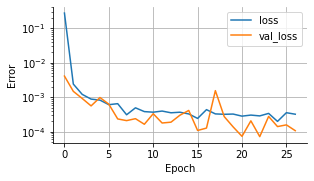

In [37]:
plot_loss(history)

In [23]:
test_dataset.describe()

,departure time,time of flight,arrival time,∆V_1,∆V_2
count,2.000000e+04,2.000000e+04,2.000000e+04,20000.000000,20000.000000
mean,7.175119e+08,2.191898e+07,7.394309e+08,3530.604966,4711.644820
std,1.239724e+06,9.705727e+06,9.796735e+06,1087.464134,1497.136341
min,7.153488e+08,5.184255e+06,7.206562e+08,0.468314,2.009950
25%,7.164499e+08,1.355339e+07,7.310552e+08,3534.958729,4634.700918
50%,7.175240e+08,2.186091e+07,7.393487e+08,3840.276633,5132.632992
75%,7.185805e+08,3.019153e+07,7.477506e+08,3980.968805,5418.155307
max,7.196687e+08,3.887921e+07,7.585045e+08,10875.163068,13702.826506


In [24]:
test_data_normalised = normalise_dataset(test_dataset.copy())
test_data_input = test_data_normalised[[column_names[0], column_names[1]]].to_numpy()
test_data_labels = test_data_normalised[[column_names[3], column_names[4]]].to_numpy()

In [25]:
prediction = model.predict(test_data_input)

In [26]:
evaluation = model.evaluate(test_data_input, test_data_labels, verbose=0)

In [27]:
pd.DataFrame(data=prediction, columns=[column_names[3], column_names[4]])

,∆V_1,∆V_2
0,-3.142110,-2.917295
1,0.247090,0.258819
2,0.361433,0.398598
3,0.482778,0.527754
4,0.696998,0.758691
...,...,...
19995,0.564926,0.602618
19996,-0.790189,-0.382192
19997,0.276625,0.209942
19998,0.132912,0.057641


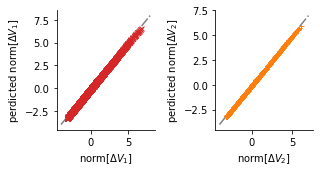

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4.55, 2.5))
ax1.plot(np.linspace(-4, 8), np.linspace(-4, 8), '-.', c='0.5')
ax2.plot(np.linspace(-4, 7), np.linspace(-4, 7), '-.', c='0.5')
ax1.plot(test_data_normalised[column_names[3]], prediction[:, 0], 'x', label=fr'$\Delta V_1$', fillstyle='none', markersize=5, c='C3', rasterized=True)
ax2.plot(test_data_normalised[column_names[4]], prediction[:, 1], '+', label=fr'$\Delta V_2$', fillstyle='none', markersize=5, c='C1', rasterized=True)


for i, ax in enumerate([ax1, ax2]):
    ax.set_ylabel(fr'perdicted norm[$\Delta V_{i+1}$]')
    ax.set_xlabel(fr'norm[$\Delta V_{i+1}$]')
#    ax.legend(frameon=False)

fig.tight_layout()
fig.savefig('case_3_pred_vs_test.pdf', dpi=450)

In [29]:
errors = pd.DataFrame(data=np.vstack((test_data_normalised[column_names[3]] - prediction[:, 0], test_data_normalised[column_names[4]] - prediction[:, 1])).T,
                      columns=["norm[∆V_1] error", "norm[∆V_2] error"])
#errors.describe()

In [30]:
errors

,norm[∆V_1] error,norm[∆V_2] error
0,0.011506,0.016103
1,0.007254,0.008986
2,0.013893,0.012331
3,0.002874,0.012870
4,0.023562,0.008294
...,...,...
19995,0.013868,0.006050
19996,0.009483,0.004571
19997,0.001208,0.007639
19998,0.014629,0.006806


In [31]:
errors.shape

(20000, 2)

In [32]:
errors_sns = errors.copy()
errors_sns.columns = ["$∆V_1$", "$∆V_2$"]
errors_sns = errors_sns.melt(value_name='norm[∆V] error')

sample_size n_layers n_nodes batch_size
100000 3 50 100 0.012965889297053104 0.010747473186710627 0.023713362483763732 0.00963336021481037 0.009307542386650793 0.01894090260146116 2.32e-04 9.84e-01


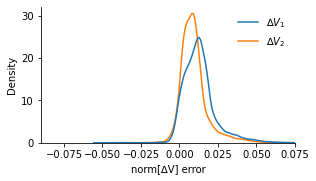

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(4.55, 2.5))

def plot_normal(data, **kwargs):
    mean, std = np.average(data), np.std(data)
    x = np.linspace(-0.2, 0.2, 1000)
    # ax.plot(x, norm.pdf(x, mean, std), **kwargs)
    print(mean, std, mean + std, end=' ', sep=' ')

print('sample_size', 'n_layers', 'n_nodes', 'batch_size')
print(sample_size, n_layers, n_nodes, batch_size, end=' ')
plot_normal(errors["norm[∆V_1] error"])
plot_normal(errors["norm[∆V_2] error"])
print(f'{evaluation[0]:.2e} {evaluation[1]:.2e}')

g = sns.kdeplot(ax=ax, data=errors_sns, x="norm[∆V] error", hue="variable")
g.set(xlim=(-0.09, 0.075))
g.get_legend().set_title(None)
g.get_legend().draw_frame(False)
fig.savefig('case_3_error_histogram.pdf')